PROJECT_ROOT: /Users/Hanjing1/JupyterProjects/biopharm-10k-ai-digital-disclosure-analysis/notebooks
PROCESSED_DIR: /Users/Hanjing1/JupyterProjects/biopharm-10k-ai-digital-disclosure-analysis/notebooks/data/processed
FIG_DIR: /Users/Hanjing1/JupyterProjects/biopharm-10k-ai-digital-disclosure-analysis/notebooks/figures

Saved panel table: /Users/Hanjing1/JupyterProjects/biopharm-10k-ai-digital-disclosure-analysis/notebooks/data/processed/module7_cross_company_panel_FY2020_FY2024.csv
Saved summary table: /Users/Hanjing1/JupyterProjects/biopharm-10k-ai-digital-disclosure-analysis/notebooks/data/processed/module7_cross_company_summary_FY2020_FY2024.csv

Summary (ranked by avg density):
                  company company_slug form_type  FY_min  FY_max  avg_density_per_10k  avg_para_hit_pct  density_2020  density_2024  density_change_2020_to_2024  coverage_pct_2020  coverage_pct_2024  coverage_change_2020_to_2024
Recursion Pharmaceuticals    recursion      10-K    2021    2024            10.58

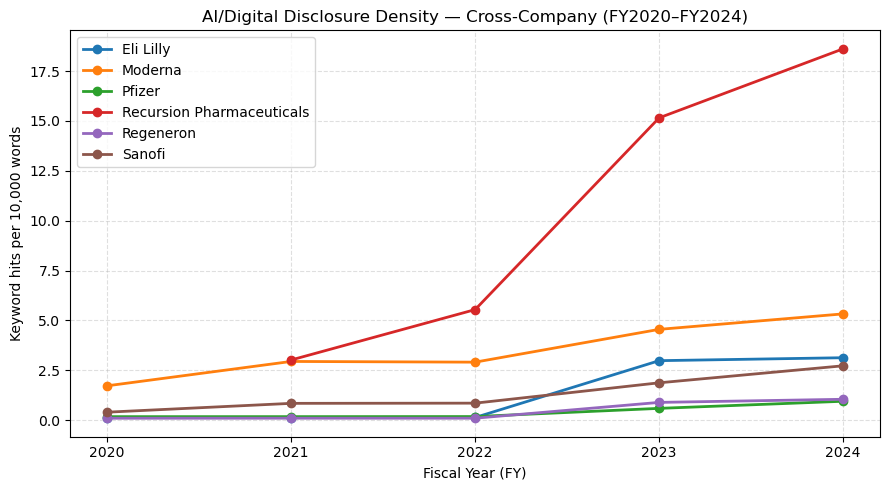

Saved figure: /Users/Hanjing1/JupyterProjects/biopharm-10k-ai-digital-disclosure-analysis/notebooks/figures/module7_cross_company_density_FY2020_FY2024.png


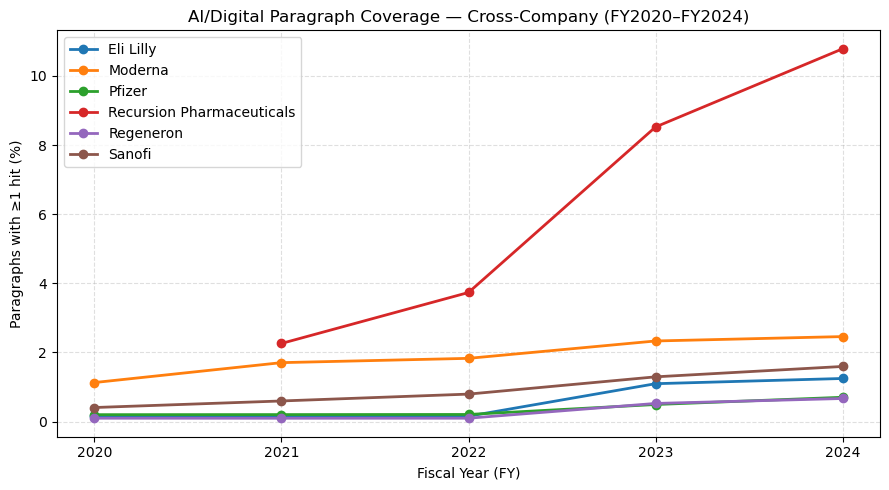

Saved figure: /Users/Hanjing1/JupyterProjects/biopharm-10k-ai-digital-disclosure-analysis/notebooks/figures/module7_cross_company_coverage_FY2020_FY2024.png


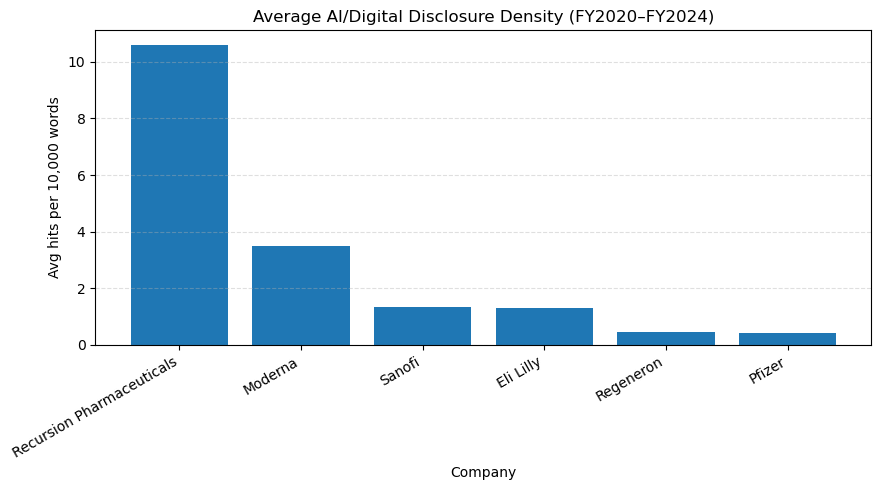

Saved figure: /Users/Hanjing1/JupyterProjects/biopharm-10k-ai-digital-disclosure-analysis/notebooks/figures/module7_avg_density_bar_FY2020_FY2024.png


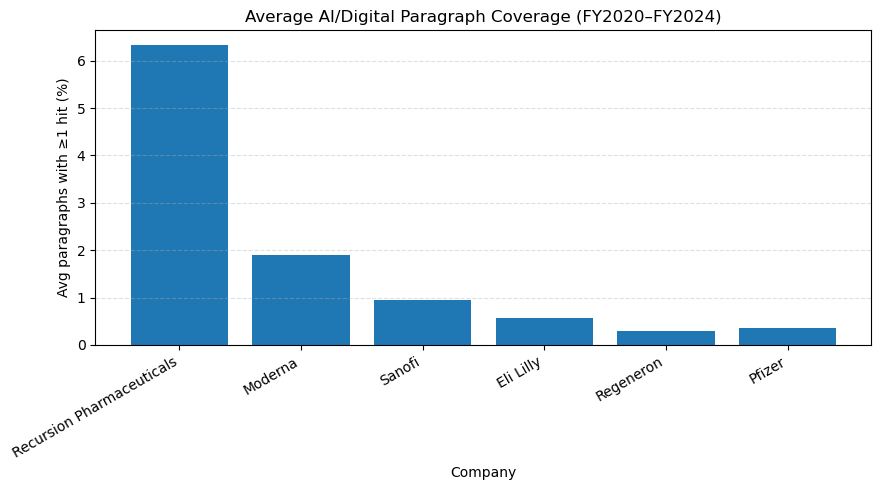

Saved figure: /Users/Hanjing1/JupyterProjects/biopharm-10k-ai-digital-disclosure-analysis/notebooks/figures/module7_avg_coverage_bar_FY2020_FY2024.png

Saved keyword pivot: /Users/Hanjing1/JupyterProjects/biopharm-10k-ai-digital-disclosure-analysis/notebooks/data/processed/module7_keyword_pivot_sum_FY2020_FY2024.csv


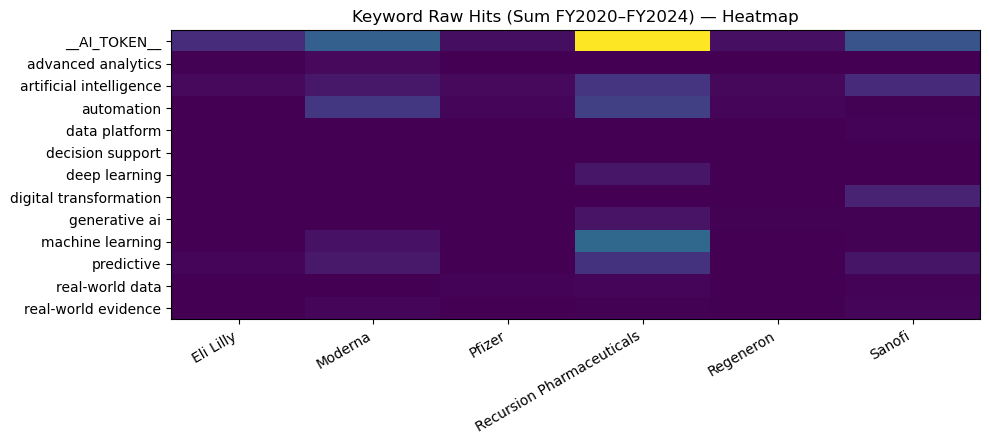

Saved figure: /Users/Hanjing1/JupyterProjects/biopharm-10k-ai-digital-disclosure-analysis/notebooks/figures/module7_keyword_heatmap_sum_FY2020_FY2024.png


In [2]:
# ============================================================
# Module 7 — Cross-Company Comparison of AI/Digital Disclosure (FY2020–FY2024)
# - Load outputs produced by Module01–Module06 from data/processed/*.csv
# - Compare across companies:
#     (1) density_per_10k (hits per 10,000 words)
#     (2) para_hit_share  (share of paragraphs with >= 1 hit)
# - Produce:
#     - combined panel table (company × FY)
#     - summary table (avg / change)
#     - figures: multi-line trends + average bar charts + keyword heatmap (optional)
# ============================================================

import os
import re
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt


# -----------------------------
# 1) Locate project dirs (robust)
# -----------------------------
def find_project_root(start_path: str) -> Path:
    p = Path(start_path).resolve()

    # Prefer git root if available
    for cand in [p] + list(p.parents):
        if (cand / ".git").exists():
            return cand

    # Otherwise: look for a sensible repo root
    for cand in [p] + list(p.parents):
        if (cand / "README.md").exists() and (cand / "data").exists():
            return cand

    # Fallback: first folder that looks like a project
    for cand in [p] + list(p.parents):
        if (cand / "data").exists() or (cand / "figures").exists() or (cand / "notebooks").exists():
            return cand

    return p


PROJECT_ROOT = find_project_root(os.getcwd())

# candidate processed dirs (support both repo-root and notebooks-root layouts)
CAND_PROCESSED_DIRS = [
    PROJECT_ROOT / "data" / "processed",
    PROJECT_ROOT / "notebooks" / "data" / "processed",
    Path(os.getcwd()) / "data" / "processed",
]
PROCESSED_DIR = next((d for d in CAND_PROCESSED_DIRS if d.exists()), None)
if PROCESSED_DIR is None:
    raise RuntimeError(
        "Could not find data/processed directory.\n"
        f"Tried:\n" + "\n".join(str(d) for d in CAND_PROCESSED_DIRS)
    )

# figures dir (prefer repo-root figures, else notebooks/figures)
CAND_FIG_DIRS = [
    PROJECT_ROOT / "figures",
    PROJECT_ROOT / "notebooks" / "figures",
    Path(os.getcwd()) / "figures",
]
FIG_DIR = next((d for d in CAND_FIG_DIRS if d.exists()), CAND_FIG_DIRS[0])
FIG_DIR.mkdir(parents=True, exist_ok=True)

OUT_DIR = PROCESSED_DIR  # save combined tables alongside module outputs

print("PROJECT_ROOT:", PROJECT_ROOT)
print("PROCESSED_DIR:", PROCESSED_DIR)
print("FIG_DIR:", FIG_DIR)


# -----------------------------
# 2) Company registry (match your module slugs)
# -----------------------------
COMPANIES = [
    {"slug": "pfizer",     "name": "Pfizer",                  "form": "10-K"},
    {"slug": "regeneron",  "name": "Regeneron",               "form": "10-K"},
    {"slug": "eli_lilly",  "name": "Eli Lilly",               "form": "10-K"},
    {"slug": "sanofi",     "name": "Sanofi",                  "form": "20-F"},
    {"slug": "moderna",    "name": "Moderna",                 "form": "10-K"},
    {"slug": "recursion",  "name": "Recursion Pharmaceuticals","form": "10-K"},
]

def _pick_latest_by_mtime(paths):
    return sorted(paths, key=lambda p: p.stat().st_mtime, reverse=True)[0]


# -----------------------------
# 3) Load per-company disclosure tables
# -----------------------------
def find_disclosure_csv(slug: str) -> Path:
    candidates = list(PROCESSED_DIR.glob(f"{slug}_ai_digital_disclosure_FY*_FY*.csv"))
    if not candidates:
        # fallback: some people name slightly differently
        candidates = list(PROCESSED_DIR.glob(f"*{slug}*ai_digital_disclosure*FY*.csv"))
    if not candidates:
        raise FileNotFoundError(f"Missing disclosure CSV for '{slug}' under {PROCESSED_DIR}")
    return _pick_latest_by_mtime(candidates)

dfs = []
for c in COMPANIES:
    path = find_disclosure_csv(c["slug"])
    df = pd.read_csv(path)

    # Normalize columns
    if "FY" not in df.columns:
        raise ValueError(f"CSV {path} has no 'FY' column.")
    df["FY"] = df["FY"].astype(int)

    if "form_type" not in df.columns:
        df["form_type"] = c["form"]

    df["company_slug"] = c["slug"]
    df["company"] = c["name"]

    # Derived metrics for plotting
    if "para_hit_share" in df.columns:
        df["para_hit_pct"] = df["para_hit_share"] * 100.0

    dfs.append(df)

panel = pd.concat(dfs, ignore_index=True)

# Keep only key columns (but don't break if your CSV contains extra columns)
keep_cols = [
    "company", "company_slug", "form_type", "FY",
    "word_count", "hit_count", "density_per_10k",
    "para_count", "para_hits", "para_hit_share", "para_hit_pct",
    "filing_url", "chosen_html",
]
panel = panel[[c for c in keep_cols if c in panel.columns]].copy()

panel_path = OUT_DIR / "module7_cross_company_panel_FY2020_FY2024.csv"
panel.to_csv(panel_path, index=False)
print("\nSaved panel table:", panel_path)


# -----------------------------
# 4) Summary table (avg + change 2020->2024)
# -----------------------------
def safe_first_last(df, col, fy0=2020, fy1=2024):
    d0 = df[df["FY"] == fy0]
    d1 = df[df["FY"] == fy1]
    v0 = float(d0[col].iloc[0]) if len(d0) else None
    v1 = float(d1[col].iloc[0]) if len(d1) else None
    return v0, v1

summary_rows = []
for (company, slug), g in panel.groupby(["company", "company_slug"]):
    g = g.sort_values("FY")

    avg_density = g["density_per_10k"].mean() if "density_per_10k" in g.columns else None
    avg_cover  = g["para_hit_pct"].mean() if "para_hit_pct" in g.columns else None

    d0, d1 = safe_first_last(g, "density_per_10k")
    c0, c1 = safe_first_last(g, "para_hit_pct")

    summary_rows.append({
        "company": company,
        "company_slug": slug,
        "form_type": g["form_type"].iloc[0] if "form_type" in g.columns and len(g) else "",
        "FY_min": int(g["FY"].min()),
        "FY_max": int(g["FY"].max()),
        "avg_density_per_10k": avg_density,
        "avg_para_hit_pct": avg_cover,
        "density_2020": d0,
        "density_2024": d1,
        "density_change_2020_to_2024": (d1 - d0) if (d0 is not None and d1 is not None) else None,
        "coverage_pct_2020": c0,
        "coverage_pct_2024": c1,
        "coverage_change_2020_to_2024": (c1 - c0) if (c0 is not None and c1 is not None) else None,
    })

summary = pd.DataFrame(summary_rows).sort_values("avg_density_per_10k", ascending=False)
summary_path = OUT_DIR / "module7_cross_company_summary_FY2020_FY2024.csv"
summary.to_csv(summary_path, index=False)
print("Saved summary table:", summary_path)

print("\nSummary (ranked by avg density):")
print(summary.to_string(index=False))


# -----------------------------
# 5) Plots — trends (multi-line)
# -----------------------------
# (A) density trend
plt.figure(figsize=(9, 5))
for company, g in panel.groupby("company"):
    g = g.sort_values("FY")
    plt.plot(g["FY"], g["density_per_10k"], marker="o", linewidth=2, label=company)
plt.title("AI/Digital Disclosure Density — Cross-Company (FY2020–FY2024)")
plt.xlabel("Fiscal Year (FY)")
plt.ylabel("Keyword hits per 10,000 words")
plt.grid(True, linestyle="--", alpha=0.4)
plt.xticks(sorted(panel["FY"].unique()))
plt.legend()
plt.tight_layout()
fig_density = FIG_DIR / "module7_cross_company_density_FY2020_FY2024.png"
plt.savefig(fig_density, dpi=300)
plt.show()
print("Saved figure:", fig_density)

# (B) coverage trend
plt.figure(figsize=(9, 5))
for company, g in panel.groupby("company"):
    g = g.sort_values("FY")
    if "para_hit_pct" in g.columns:
        plt.plot(g["FY"], g["para_hit_pct"], marker="o", linewidth=2, label=company)
plt.title("AI/Digital Paragraph Coverage — Cross-Company (FY2020–FY2024)")
plt.xlabel("Fiscal Year (FY)")
plt.ylabel("Paragraphs with ≥1 hit (%)")
plt.grid(True, linestyle="--", alpha=0.4)
plt.xticks(sorted(panel["FY"].unique()))
plt.legend()
plt.tight_layout()
fig_cov = FIG_DIR / "module7_cross_company_coverage_FY2020_FY2024.png"
plt.savefig(fig_cov, dpi=300)
plt.show()
print("Saved figure:", fig_cov)


# -----------------------------
# 6) Plots — averages (bar)
# -----------------------------
plt.figure(figsize=(9, 5))
plt.bar(summary["company"], summary["avg_density_per_10k"])
plt.title("Average AI/Digital Disclosure Density (FY2020–FY2024)")
plt.xlabel("Company")
plt.ylabel("Avg hits per 10,000 words")
plt.xticks(rotation=30, ha="right")
plt.grid(True, axis="y", linestyle="--", alpha=0.4)
plt.tight_layout()
fig_avg_density = FIG_DIR / "module7_avg_density_bar_FY2020_FY2024.png"
plt.savefig(fig_avg_density, dpi=300)
plt.show()
print("Saved figure:", fig_avg_density)

plt.figure(figsize=(9, 5))
plt.bar(summary["company"], summary["avg_para_hit_pct"])
plt.title("Average AI/Digital Paragraph Coverage (FY2020–FY2024)")
plt.xlabel("Company")
plt.ylabel("Avg paragraphs with ≥1 hit (%)")
plt.xticks(rotation=30, ha="right")
plt.grid(True, axis="y", linestyle="--", alpha=0.4)
plt.tight_layout()
fig_avg_cov = FIG_DIR / "module7_avg_coverage_bar_FY2020_FY2024.png"
plt.savefig(fig_avg_cov, dpi=300)
plt.show()
print("Saved figure:", fig_avg_cov)


# -----------------------------
# 7) Optional — keyword breakdown heatmap (sum over FY range)
# -----------------------------
def find_kw_csv(slug: str) -> Path:
    candidates = list(PROCESSED_DIR.glob(f"{slug}_ai_digital_keyword_breakdown_FY*_FY*.csv"))
    if not candidates:
        candidates = list(PROCESSED_DIR.glob(f"*{slug}*keyword_breakdown*FY*.csv"))
    if not candidates:
        return None
    return _pick_latest_by_mtime(candidates)

kw_frames = []
for c in COMPANIES:
    p = find_kw_csv(c["slug"])
    if p is None:
        continue
    dfk = pd.read_csv(p)
    if "FY" in dfk.columns:
        dfk["FY"] = dfk["FY"].astype(int)
        dfk = dfk[(dfk["FY"] >= 2020) & (dfk["FY"] <= 2024)]
    dfk["company"] = c["name"]
    dfk["company_slug"] = c["slug"]
    kw_frames.append(dfk)

if kw_frames:
    kw_all = pd.concat(kw_frames, ignore_index=True)

    # Pivot: keyword × company (sum raw hits across FY2020-2024)
    kw_pivot = (
        kw_all.groupby(["keyword", "company"], as_index=False)["raw_hits"].sum()
        .pivot(index="keyword", columns="company", values="raw_hits")
        .fillna(0.0)
        .sort_index()
    )

    kw_pivot_path = OUT_DIR / "module7_keyword_pivot_sum_FY2020_FY2024.csv"
    kw_pivot.to_csv(kw_pivot_path)
    print("\nSaved keyword pivot:", kw_pivot_path)

    # Heatmap (matplotlib default colormap)
    plt.figure(figsize=(10, max(4, 0.35 * len(kw_pivot.index))))
    plt.imshow(kw_pivot.values, aspect="auto")
    plt.title("Keyword Raw Hits (Sum FY2020–FY2024) — Heatmap")
    plt.yticks(range(len(kw_pivot.index)), kw_pivot.index)
    plt.xticks(range(len(kw_pivot.columns)), kw_pivot.columns, rotation=30, ha="right")
    plt.tight_layout()
    fig_heat = FIG_DIR / "module7_keyword_heatmap_sum_FY2020_FY2024.png"
    plt.savefig(fig_heat, dpi=300)
    plt.show()
    print("Saved figure:", fig_heat)
else:
    print("\n[INFO] No keyword breakdown CSVs found; skipped keyword heatmap.")
